In [42]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import folium
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from pathlib import Path
import numpy as np

In [10]:
stops_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/stops.txt")
routes_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/routes.txt")
trips_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/trips.txt")
shapes_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/shapes.txt")
stop_times_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/stop_times.txt")


In [23]:
#We remove the routes that are in the municipality of Rovereto
routes_to_remove = [
    578, 580, 582, 590, 592, 594, 598, 601, 602, 605, 
    607, 610, 612, 613, 512, 562, 563, 566, 531 #We are also removing the "Funivia", as it is not a bus transport
]

routes = routes_full[~routes_full['route_id'].isin(routes_to_remove)]

# Then filter GTFS tables
trips = trips_full[trips_full['route_id'].isin(routes['route_id'])]
stop_times = stop_times_full[stop_times_full['trip_id'].isin(trips['trip_id'])]
shapes = shapes_full[shapes_full['shape_id'].isin(trips['shape_id'])]
stops = stops_full[stops_full['stop_id'].isin(stop_times['stop_id'])]


In [14]:
# Get a mapping from route_id to shape_ids
route_shape_df = trips[['route_id', 'shape_id']].drop_duplicates()

# Merge shapes with route info
shapes_merged = shapes.merge(route_shape_df, on='shape_id')

# Optional: sort shapes by sequence
shapes_merged = shapes_merged.sort_values(by=['route_id', 'shape_id', 'shape_pt_sequence'])


In [35]:

def save_as_img(m, name):
    m.save(f"{name}.html")

    # === 3. Convert HTML to PNG with Selenium ===
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=options)
    driver.set_window_size(1200, 800)  # bigger size for better resolution
    map_path = Path(f"{name}.html").resolve().as_uri()
    driver.get(map_path)

    # Wait for map tiles to load
    time.sleep(3)

    driver.save_screenshot(f"{name}.png")
    driver.quit()

In [38]:
m = folium.Map(location=[46.0667, 11.1167], zoom_start=13)

colors = plt.cm.get_cmap('tab20', len(shapes_merged['route_id'].unique()))
route_colors = {
    route: f'#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}'
    for i, route in enumerate(shapes_merged['route_id'].unique())
}

# Add route polylines
for route_id, group in shapes_merged.groupby('route_id'):
    color = route_colors[route_id]
    for shape_id, shape_group in group.groupby('shape_id'):
        coords = shape_group[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
        folium.PolyLine(
            coords,
            color=color,
            weight=3,
            opacity=0.7,
            popup=f"Route {route_id}"
        ).add_to(m)

save_as_img(m, "routes")

m


/tmp/ipykernel_4760/4141377058.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(shapes_merged['route_id'].unique()))


In [39]:
# Join stop_times with trips to get route_id info
stop_times_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')

# Count how many times each stop is visited
stop_counts = stop_times_trips.groupby('stop_id').size().reset_index(name='stop_frequency')

# Merge with stop locations
stops_freq = stops.merge(stop_counts, on='stop_id')


In [40]:
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(stops_freq.stop_lon, stops_freq.stop_lat)]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs="EPSG:4326")

In [43]:
# Convert to metric CRS for spatial binning
gdf = gdf.to_crs(epsg=3857)

# Define grid size (e.g. 500 meters)
xmin, ymin, xmax, ymax = gdf.total_bounds
cell_size = 500  # meters

cols = list(np.arange(xmin, xmax, cell_size))
rows = list(np.arange(ymin, ymax, cell_size))

polygons = []
for x in cols:
    for y in rows:
        polygons.append(box(x, y, x+cell_size, y+cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf.crs)


In [44]:
# Spatial join: assign each stop to a grid cell
join = gpd.sjoin(gdf, grid, how="left", predicate="within")

# Aggregate: sum stop frequencies per zone
zone_freq = join.groupby('index_right')['stop_frequency'].sum().reset_index()
# Create bus_frequency column initialized to 0
grid['bus_frequency'] = 0

# Assign the frequencies from zone_freq where available
for idx, freq in zip(zone_freq['index_right'], zone_freq['stop_frequency']):
    grid.at[idx, 'bus_frequency'] = freq


In [49]:
grid = grid.to_crs(epsg=4326)

m = folium.Map(location=[46.0667, 11.1167], zoom_start=14)

# Add choropleth
folium.Choropleth(
    geo_data=grid,
    data=grid,
    columns=[grid.index, 'bus_frequency'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Bus Transit Frequency'
).add_to(m)

save_as_img(m, "Bus_transit_frequency_abs")

m


In [60]:
## We now filter the stops based on hour of the day
# --- Extract Hour from stop_times ---
def parse_hour(time_str):
    if pd.isna(time_str): return None
    try:
        hour = int(time_str.split(':')[0]) % 24
        return hour
    except:
        return None

stop_times['hour'] = stop_times['arrival_time'].apply(parse_hour)
stop_times = stop_times.dropna(subset=['hour'])

# --- Join stop_times + trips + stops ---
df = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')
df = df.merge(stops[['stop_id', 'stop_lat', 'stop_lon']], on='stop_id')

# --- Filter by Hour Range (e.g. 7–10 AM) ---
hour_start = 0
hour_end = 23
df_filtered = df[(df['hour'] >= hour_start) & (df['hour'] <= hour_end)]

# --- Convert to GeoDataFrame ---
df_filtered['geometry'] = df_filtered.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
gdf = gpd.GeoDataFrame(df_filtered, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# --- Create Grid (500m squares) ---
xmin, ymin, xmax, ymax = gdf.total_bounds
cell_size = 500  # meters

cols = np.arange(xmin, xmax, cell_size)
rows = np.arange(ymin, ymax, cell_size)
grid_cells = [box(x, y, x+cell_size, y+cell_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs).reset_index(drop=True)

# --- Spatial Join: assign stops to grid cells ---
joined = gpd.sjoin(gdf[['geometry']], grid, how="left", predicate="within")

# --- Aggregate counts per grid cell ---
freq = joined.groupby('index_right').size().reset_index(name='count')

# --- Merge frequency into grid ---
grid['count'] = 0
for idx, cnt in zip(freq['index_right'], freq['count']):
    grid.at[idx, 'count'] = cnt

# --- Convert grid to WGS84 and plot ---
grid = grid.to_crs(epsg=4326)

# --- Log scale option ---
grid['count'] = grid['count'].fillna(0)
grid['log_count'] = grid['count'].apply(lambda x: np.log1p(x))  # log(1 + x)

# --- OR cap max for color scale (95th percentile) ---
cap = grid['count'].quantile(0.95)
grid['clipped_count'] = grid['count'].apply(lambda x: min(x, cap))


m = folium.Map(location=[46.0667, 11.1167], zoom_start=13)

folium.Choropleth(
    geo_data=grid,
    data=grid,
    columns=[grid.index, 'log_count'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f'Clipped Bus Frequency ({hour_start}:00 to {hour_end}:00)',
    nan_fill_color='white'
).add_to(m)


m


In [33]:
from shapely.geometry import Polygon

# Example: Bus Station zone (define lat/lon box around it)
bus_station_polygon = Polygon([
    (11.115, 46.066),
    (11.117, 46.066),
    (11.117, 46.067),
    (11.115, 46.067)
])

# Example: City Center zone
city_center_polygon = Polygon([
    (11.120, 46.066),
    (11.123, 46.066),
    (11.123, 46.068),
    (11.120, 46.068)
])

zones = gpd.GeoDataFrame({
    'zone_name': ['Bus Station', 'City Center'],
    'geometry': [bus_station_polygon, city_center_polygon]
}, crs="EPSG:4326").to_crs(epsg=3857)


In [34]:
# gdf: stop events with geometry and hour (already in EPSG:3857)
joined_zones = gpd.sjoin(gdf[['hour', 'geometry']], zones, how="inner", predicate="within")
zone_hour_freq = joined_zones.groupby(['zone_name', 'hour']).size().reset_index(name='count')


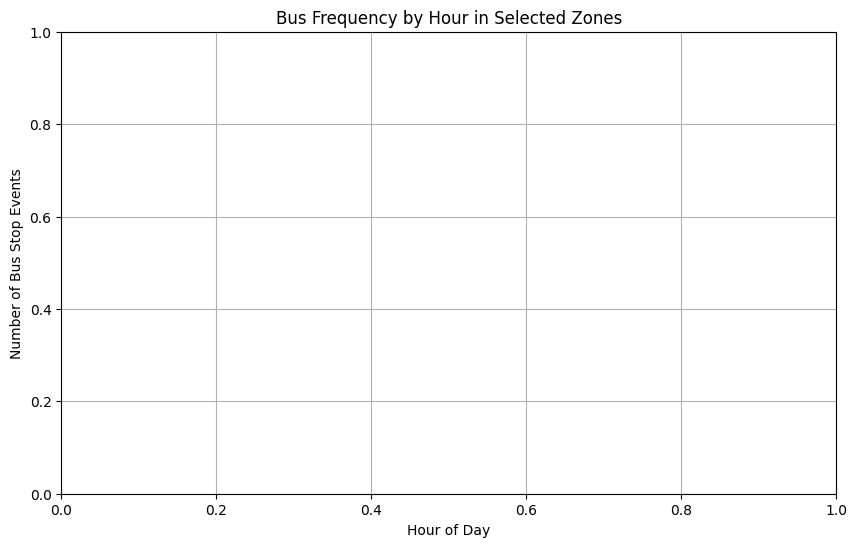

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=zone_hour_freq, x='hour', y='count', hue='zone_name', marker="o")
plt.title("Bus Frequency by Hour in Selected Zones")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Bus Stop Events")
plt.grid(True)
plt.show()


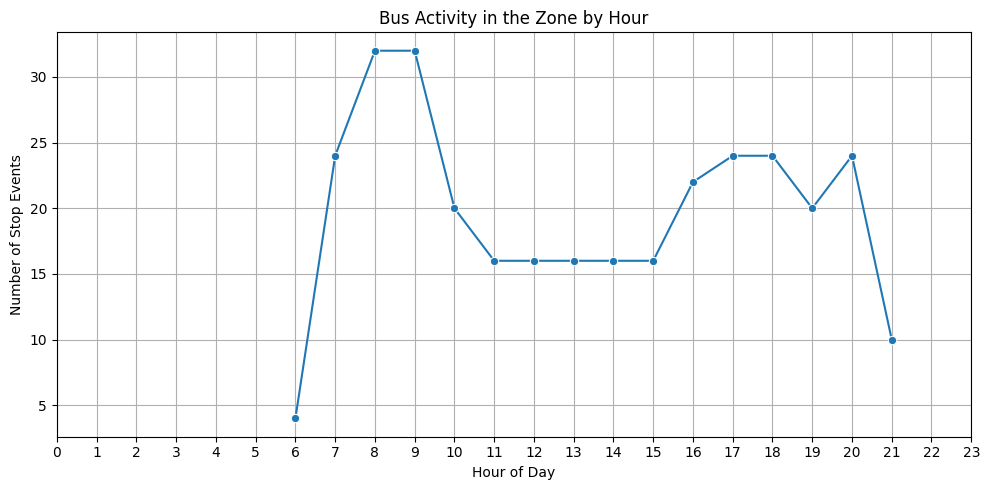

In [59]:
# --- Imports ---
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns


# --- Parse hour from arrival_time ---
def parse_hour(time_str):
    if pd.isna(time_str): return None
    try:
        h = int(time_str.split(':')[0]) % 24
        return h
    except:
        return None

stop_times['hour'] = stop_times['arrival_time'].apply(parse_hour)
stop_times = stop_times.dropna(subset=['hour'])

# --- Merge stop_times + trips + stops ---
df = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')
df = df.merge(stops[['stop_id', 'stop_lat', 'stop_lon']], on='stop_id')

# --- Convert to GeoDataFrame ---
df['geometry'] = df.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# --- Define your polygon zone (example: Bus Station) ---
# You can adjust these coordinates or use latlong.net to find them
zone_polygon = Polygon([
    (11.1145, 46.0660),  # bottom-left
    (11.1180, 46.0660),  # bottom-right
    (11.1180, 46.0678),  # top-right
    (11.1145, 46.0678)   # top-left
])



zone = gpd.GeoDataFrame({'zone_name': ['Bus Station'], 'geometry': [zone_polygon]}, crs="EPSG:4326").to_crs(epsg=3857)

# --- Spatial join: match stop events to zone ---
joined = gpd.sjoin(gdf[['hour', 'geometry']], zone, how="inner", predicate="within")

# --- Count events per hour in the zone ---
hourly_counts = joined.groupby('hour').size().reset_index(name='count')

# --- Plot frequency over hours ---
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_counts, x='hour', y='count', marker='o')
plt.title("Bus Activity in the Zone by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Stop Events")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


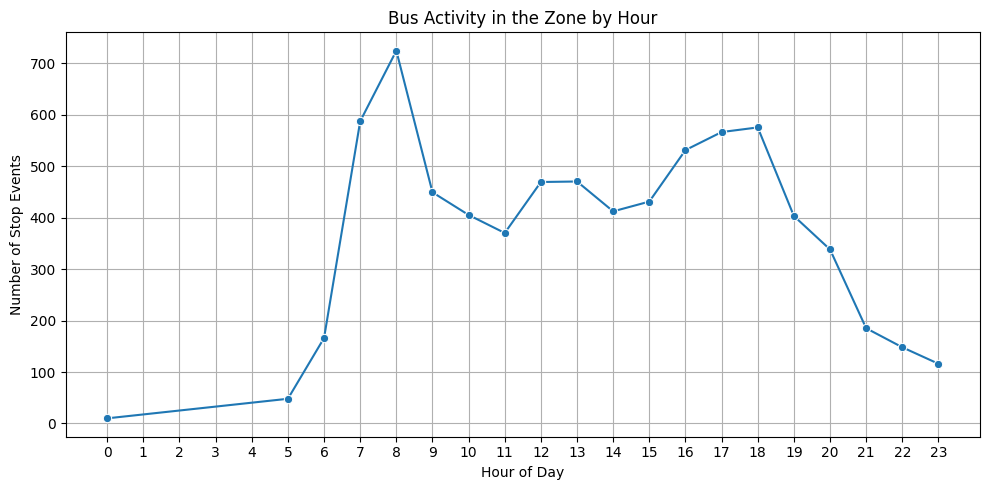

In [58]:
from shapely.geometry import Polygon
import geopandas as gpd
import math

# --- Center point ---
lat_center = 46.067527
lon_center = 11.150486

# --- Half side of square in meters ---
half_side_m = 1000  # 250 meters in all directions → 500m x 500m square

# --- Convert meters to degrees ---
deg_lat = half_side_m / 111000  # ~0.00225 degrees
deg_lon = half_side_m / (111000 * math.cos(math.radians(lat_center)))  # adjusted for latitude
# --- Define square corners (lon, lat order) ---
square_coords = [
    (lon_center - deg_lon, lat_center - deg_lat),  # bottom-left
    (lon_center + deg_lon, lat_center - deg_lat),  # bottom-right
    (lon_center + deg_lon, lat_center + deg_lat),  # top-right
    (lon_center - deg_lon, lat_center + deg_lat),  # top-left
]

# --- Create Polygon and GeoDataFrame ---
square_poly = Polygon(square_coords)
zone = gpd.GeoDataFrame({'zone_name': ['500m_zone'], 'geometry': [square_poly]}, crs="EPSG:4326").to_crs(epsg=3857)

# --- Spatial join: match stop events to zone ---
joined = gpd.sjoin(gdf[['hour', 'geometry']], zone, how="inner", predicate="within")

# --- Count events per hour in the zone ---
hourly_counts = joined.groupby('hour').size().reset_index(name='count')

# --- Plot frequency over hours ---
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_counts, x='hour', y='count', marker='o')
plt.title("Bus Activity in the Zone by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Stop Events")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
def bus_per_hour(center_point, size):
    lon_center = center_point[1]
    lat_center = center_point[0]

    half_side_m = size/2  # 250 meters in all directions → 500m x 500m square

    # --- Convert meters to degrees ---
    deg_lat = half_side_m / 111000  # ~0.00225 degrees
    deg_lon = half_side_m / (111000 * math.cos(math.radians(lat_center)))  # adjusted for latitude
    # --- Define square corners (lon, lat order) ---
    square_coords = [
        (lon_center - deg_lon, lat_center - deg_lat),  # bottom-left
        (lon_center + deg_lon, lat_center - deg_lat),  # bottom-right
        (lon_center + deg_lon, lat_center + deg_lat),  # top-right
        (lon_center - deg_lon, lat_center + deg_lat),  # top-left
    ]

    # --- Create Polygon and GeoDataFrame ---
    square_poly = Polygon(square_coords)
    zone = gpd.GeoDataFrame({'zone_name': ['500m_zone'], 'geometry': [square_poly]}, crs="EPSG:4326").to_crs(epsg=3857)

    # --- Spatial join: match stop events to zone ---
    joined = gpd.sjoin(gdf[['hour', 'geometry']], zone, how="inner", predicate="within")

    # --- Count events per hour in the zone ---
    hourly_counts = joined.groupby('hour').size().reset_index(name='count')

    # --- Plot frequency over hours ---
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=hourly_counts, x='hour', y='count', marker='o')
    plt.title("Bus Activity in the Zone by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Stop Events")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

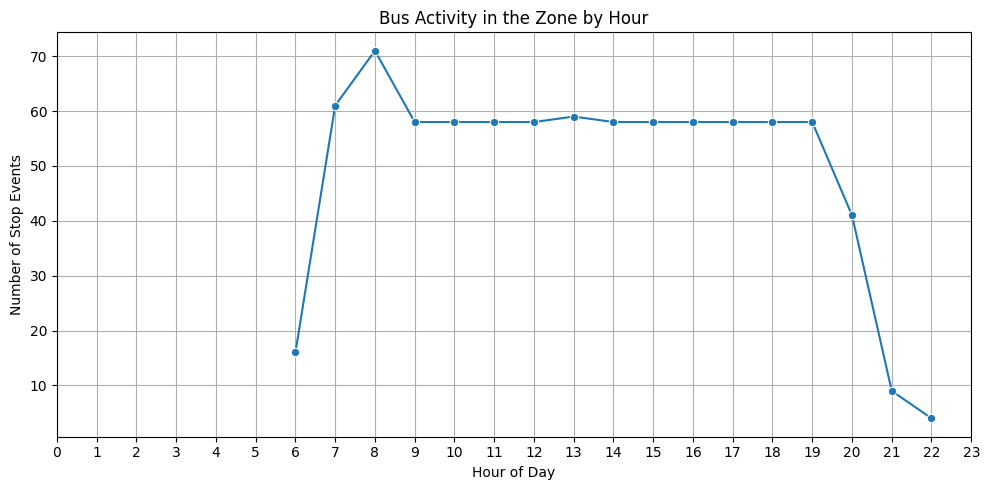

In [63]:
hospital = (46.055569,11.132340)
size = 500
bus_per_hour(center_point, size)

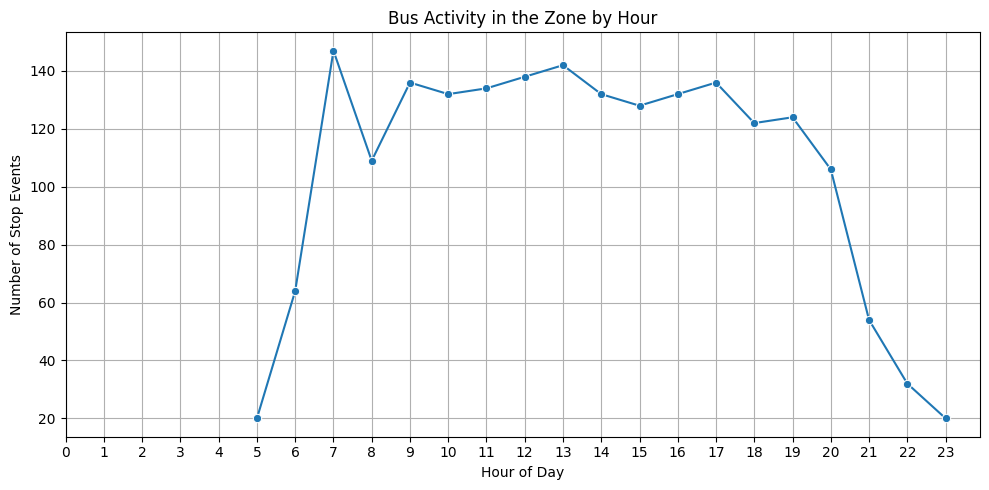

In [72]:
sanbapolis = (46.046395,11.132544)
size = 500
bus_per_hour(sanbapolis, size)

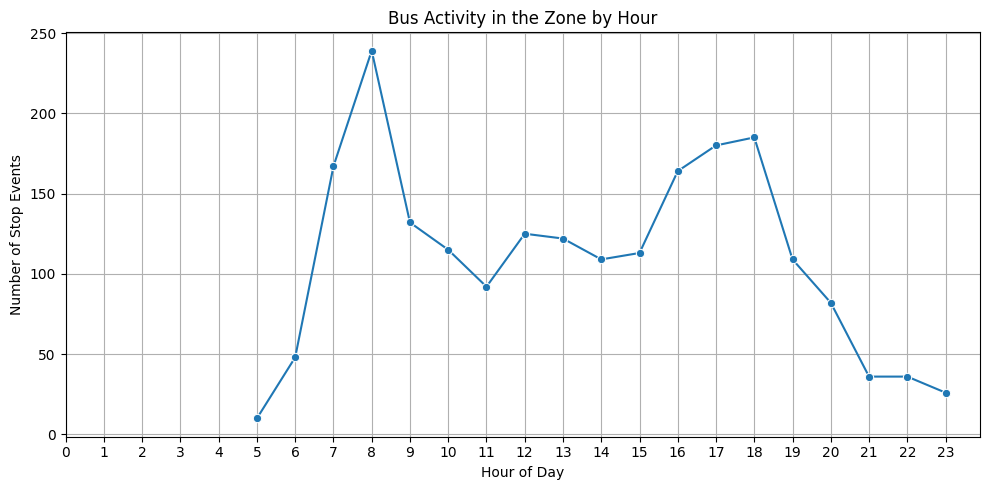

In [67]:
povo = (46.067527,11.150486)
size = 1000
bus_per_hour(povo, size)

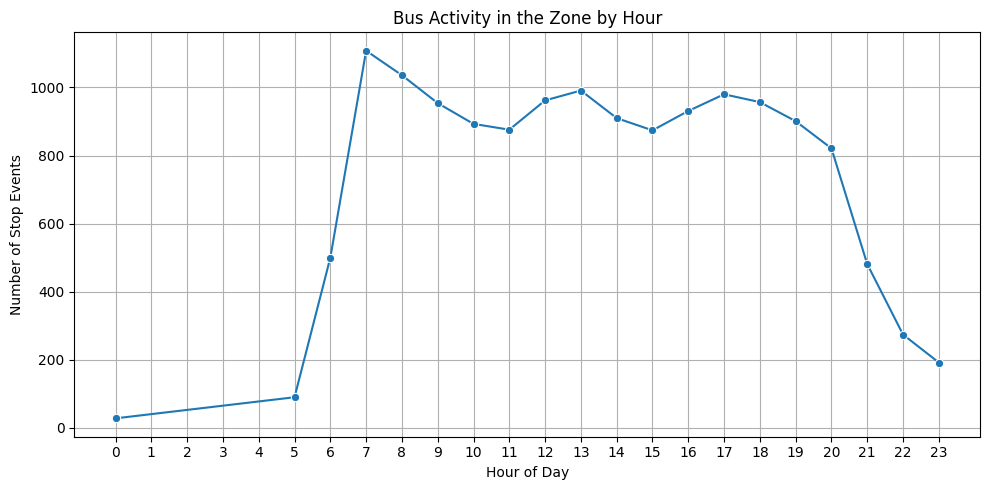

In [69]:
stazione = (46.074077,11.120666)
size = 1000
bus_per_hour(stazione, size)

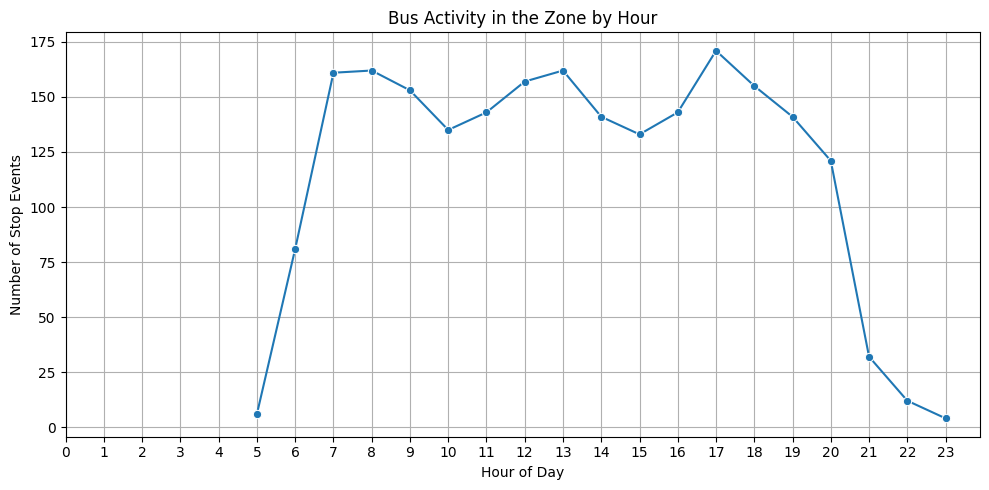

In [71]:
muse = (46.063259,11.113125)
size = 1000
bus_per_hour(muse, size)

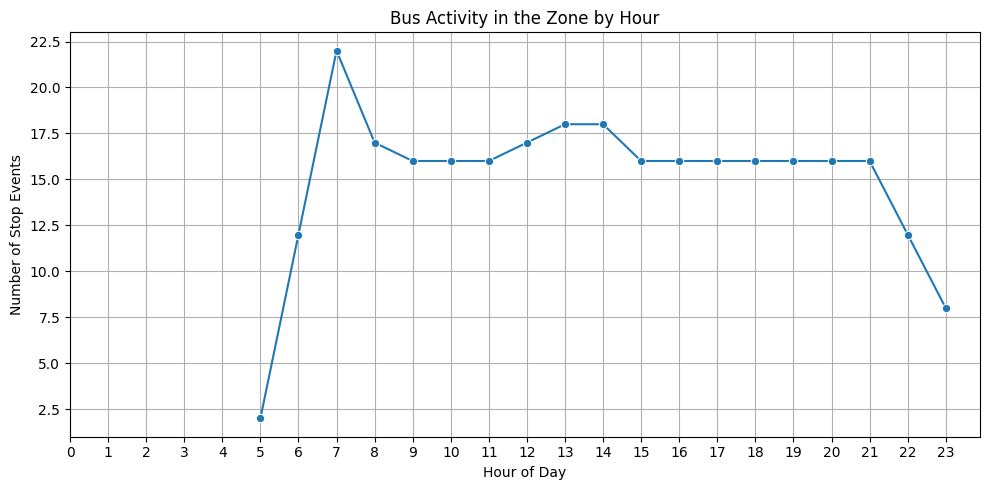

In [76]:
liceo_galilei= (46.06325, 11.13631)
size = 400
bus_per_hour(liceo_galilei, size)